In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from PIL import Image
from tqdm import tqdm
import requests


In [14]:
# Additional imports for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


In [3]:
# 1. **Dataset Download and Extraction**

# Define dataset and zip file paths
data_dir = '/kaggle/working/Plant_leave_diseases_dataset_without_augmentation'
zip_file_path = '/kaggle/working/plantvillage.zip'

# The URL provided is a Mendeley Data URL, which may not allow direct download.
# If the download fails, you need to upload the dataset to Kaggle Datasets and add it to your notebook.
data_url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"  # Replace with direct download link if available

def download_and_extract_dataset(data_dir, zip_file_path, data_url):
    if not os.path.exists(data_dir):
        # Step 1: Download the dataset if the zip file doesn't exist
        if not os.path.exists(zip_file_path):
            print("Downloading the dataset...")
            try:
                response = requests.get(data_url, stream=True)
                response.raise_for_status()  # Raise an exception for bad status codes

                total_size = int(response.headers.get('content-length', 0))
                block_size = 1024
                progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc='Downloading')

                with open(zip_file_path, 'wb') as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                print("\nDownload Complete")
            except requests.exceptions.RequestException as e:
                raise Exception(f"Error during download: {e}")

        # Step 2: Extract the zip file
        print("Extracting the archive...")
        try:
            shutil.unpack_archive(zip_file_path, "/kaggle/working")
        except shutil.ReadError as e:
            raise Exception(f"Extraction failed: {e}")

        # Step 3: Handle nested directories if present
        # Often, zip files contain an extra directory layer. Adjust accordingly.
        extracted_dirs = [name for name in os.listdir("/kaggle/working") 
                          if os.path.isdir(os.path.join("/kaggle/working", name)) and name != "Plant_leave_diseases_dataset_without_augmentation"]
        if extracted_dirs:
            # If there's an extra directory layer, move its contents up
            for extracted_dir in extracted_dirs:
                src_path = os.path.join("/kaggle/working", extracted_dir)
                dst_path = os.path.join("/kaggle/working", "Plant_leave_diseases_dataset_without_augmentation")
                os.makedirs(dst_path, exist_ok=True)
                # Move all contents from src_path to dst_path
                for item in os.listdir(src_path):
                    s = os.path.join(src_path, item)
                    d = os.path.join(dst_path, item)
                    shutil.move(s, d)
                # Remove the now-empty extracted_dir
                shutil.rmtree(src_path)
        print("Dataset Downloaded and Unzipped")
    else:
        print("Dataset already exists. Skipping download and extraction.")

# Execute dataset download and extraction
download_and_extract_dataset(data_dir, zip_file_path, data_url)

# 2. **Set Random Seed**
random_seed = 49
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# 3. **List All Image Paths and Labels**
image_paths = []
labels = []

# Assuming each subfolder in data_dir corresponds to a class
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder_path, file_name))
                labels.append(folder_name)

print(f"Total images found: {len(image_paths)}")
print(f"Total classes found: {len(set(labels))}")


Downloading: 100%|██████████| 868M/868M [01:16<00:00, 11.3MiB/s]   



Download Complete
Extracting the archive...
Dataset Downloaded and Unzipped
Total images found: 55448
Total classes found: 39


In [5]:
# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
indices = [label_to_index[label] for label in labels]
class_names = sorted(set(labels))
num_classes = len(class_names)

# 4. **Split into Train, Validation, and Test Sets**
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    list(range(len(indices))),
    indices,
    test_size=0.3,
    stratify=indices,
    random_state=random_seed
)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=random_seed
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")

# 5. **Compute Class Weights to Handle Class Imbalance**
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print(f"Computed class weights: {class_weights}")

# 6. **Data Pipeline with tf.data API**

# Define Image Size and Batch Size
image_size = (128, 128)
batch_size = 32

# Define Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1),
    # Add more augmentations if needed
])

# Preprocessing Function
def preprocess_image(image_path, label, augment=False):
    # Read the image from disk
    image = tf.io.read_file(image_path)
    # Decode the image (handles JPEG and PNG formats)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    if augment:
        image = data_augmentation(image)
    
    return image, tf.one_hot(label, depth=num_classes)

# Create TensorFlow Datasets
def create_tf_dataset(image_paths, labels, augment=False, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=random_seed)
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = create_tf_dataset([image_paths[i] for i in train_indices],
                                  [indices[i] for i in train_indices],
                                  augment=True,
                                  shuffle=True)

val_dataset = create_tf_dataset([image_paths[i] for i in val_indices],
                                [indices[i] for i in val_indices],
                                augment=False,
                                shuffle=False)

test_dataset = create_tf_dataset([image_paths[i] for i in test_indices],
                                 [indices[i] for i in test_indices],
                                 augment=False,
                                 shuffle=False)


Training samples: 38813
Validation samples: 8317
Test samples: 8318
Computed class weights: {0: 2.256700970986685, 1: 2.2878278809313293, 2: 5.156503254948851, 3: 0.8638933404558404, 4: 1.2440064102564103, 5: 0.9469125863036424, 6: 1.3521808807134894, 7: 1.6642226224166023, 8: 2.772159131490608, 9: 1.1932915206296502, 10: 1.4423262727610553, 11: 1.224114548837796, 12: 1.2048488234928914, 13: 1.0281044712862895, 14: 1.3216535567133176, 15: 3.3621794871794872, 16: 0.2581595663307726, 17: 0.6189086618191095, 18: 3.949226699226699, 19: 1.4257953126147969, 20: 0.9615508485073703, 21: 1.4217216117216118, 22: 1.4217216117216118, 23: 9.388727624576681, 24: 3.8277120315581854, 25: 0.279316623128018, 26: 0.7750818755491653, 27: 1.282480835315887, 28: 3.1197652921790855, 29: 0.668371476296258, 30: 1.4217216117216118, 31: 0.7449140181176109, 32: 1.4943019943019944, 33: 0.8025847808105873, 34: 0.848427219271209, 35: 1.0124162036674753, 36: 0.2653880341880342, 37: 3.813046468218882, 38: 0.8933618745

In [6]:
# 8. **Model Definition, Compilation, and Fine-Tuning**

# Import the DenseNet201 model
from tensorflow.keras.applications import DenseNet201

# Load the pre-trained DenseNet201 model without specifying input_shape
densenet = DenseNet201(
    include_top=False,
    weights='imagenet',
    pooling=None
)

# Unfreeze the base model for fine-tuning
densenet.trainable = True

# Define the model with an InputLayer
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()



74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39)                  │          74,919 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,396,903 (70.18 MB)

 Trainable params: 18,167,847 (69.30 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [7]:
# Set up callbacks
checkpoint_dir = '/kaggle/working/model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]
total_epochs = 20


In [8]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=total_epochs,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy after fine-tuning: {test_accuracy:.4f}')

# Save the final model
model.save('/kaggle/working/final_model_finetuned.h5')


Epoch 1/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.1142 - loss: 3.4321
Epoch 1: val_accuracy improved from -inf to 0.70675, saving model to /kaggle/working/model_checkpoints/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 633s 310ms/step - accuracy: 0.1143 - loss: 3.4317 - val_accuracy: 0.7067 - val_loss: 1.0871 - learning_rate: 1.0000e-05
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4059 - loss: 2.2010
Epoch 2: val_accuracy improved from 0.70675 to 0.85403, saving model to /kaggle/working/model_checkpoints/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 198s 163ms/step - accuracy: 0.4059 - loss: 2.2010 - val_accuracy: 0.8540 - val_loss: 0.4853 - learning_rate: 1.0000e-05
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4559 - loss: 2.0196
Epoch 3: val_accuracy improved from 0.85403 to 0.88614, saving model to /kaggle/working/model_checkpoints/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 196s 162ms/step - accuracy: 0.4

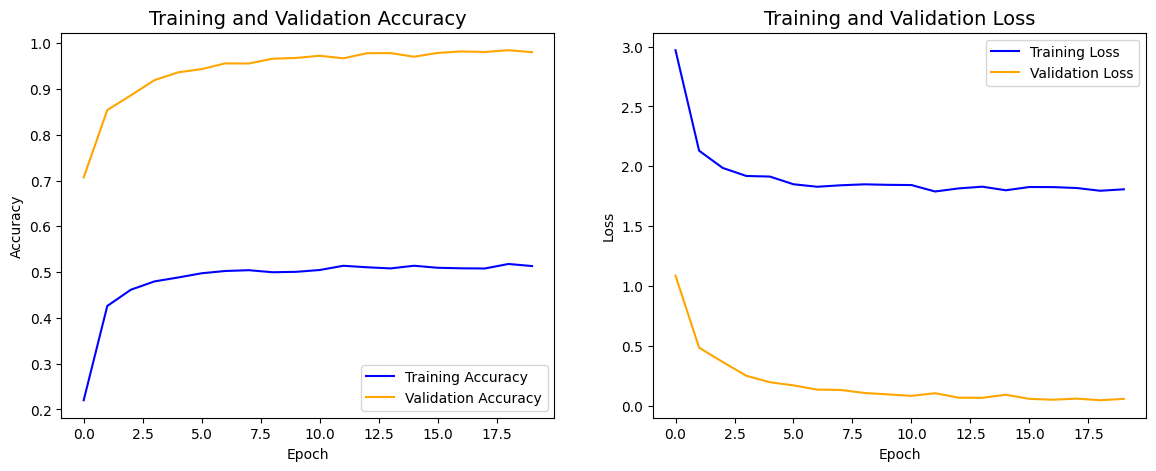

In [10]:
# 8. **Plot Training and Validation Accuracy and Loss Curves**

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

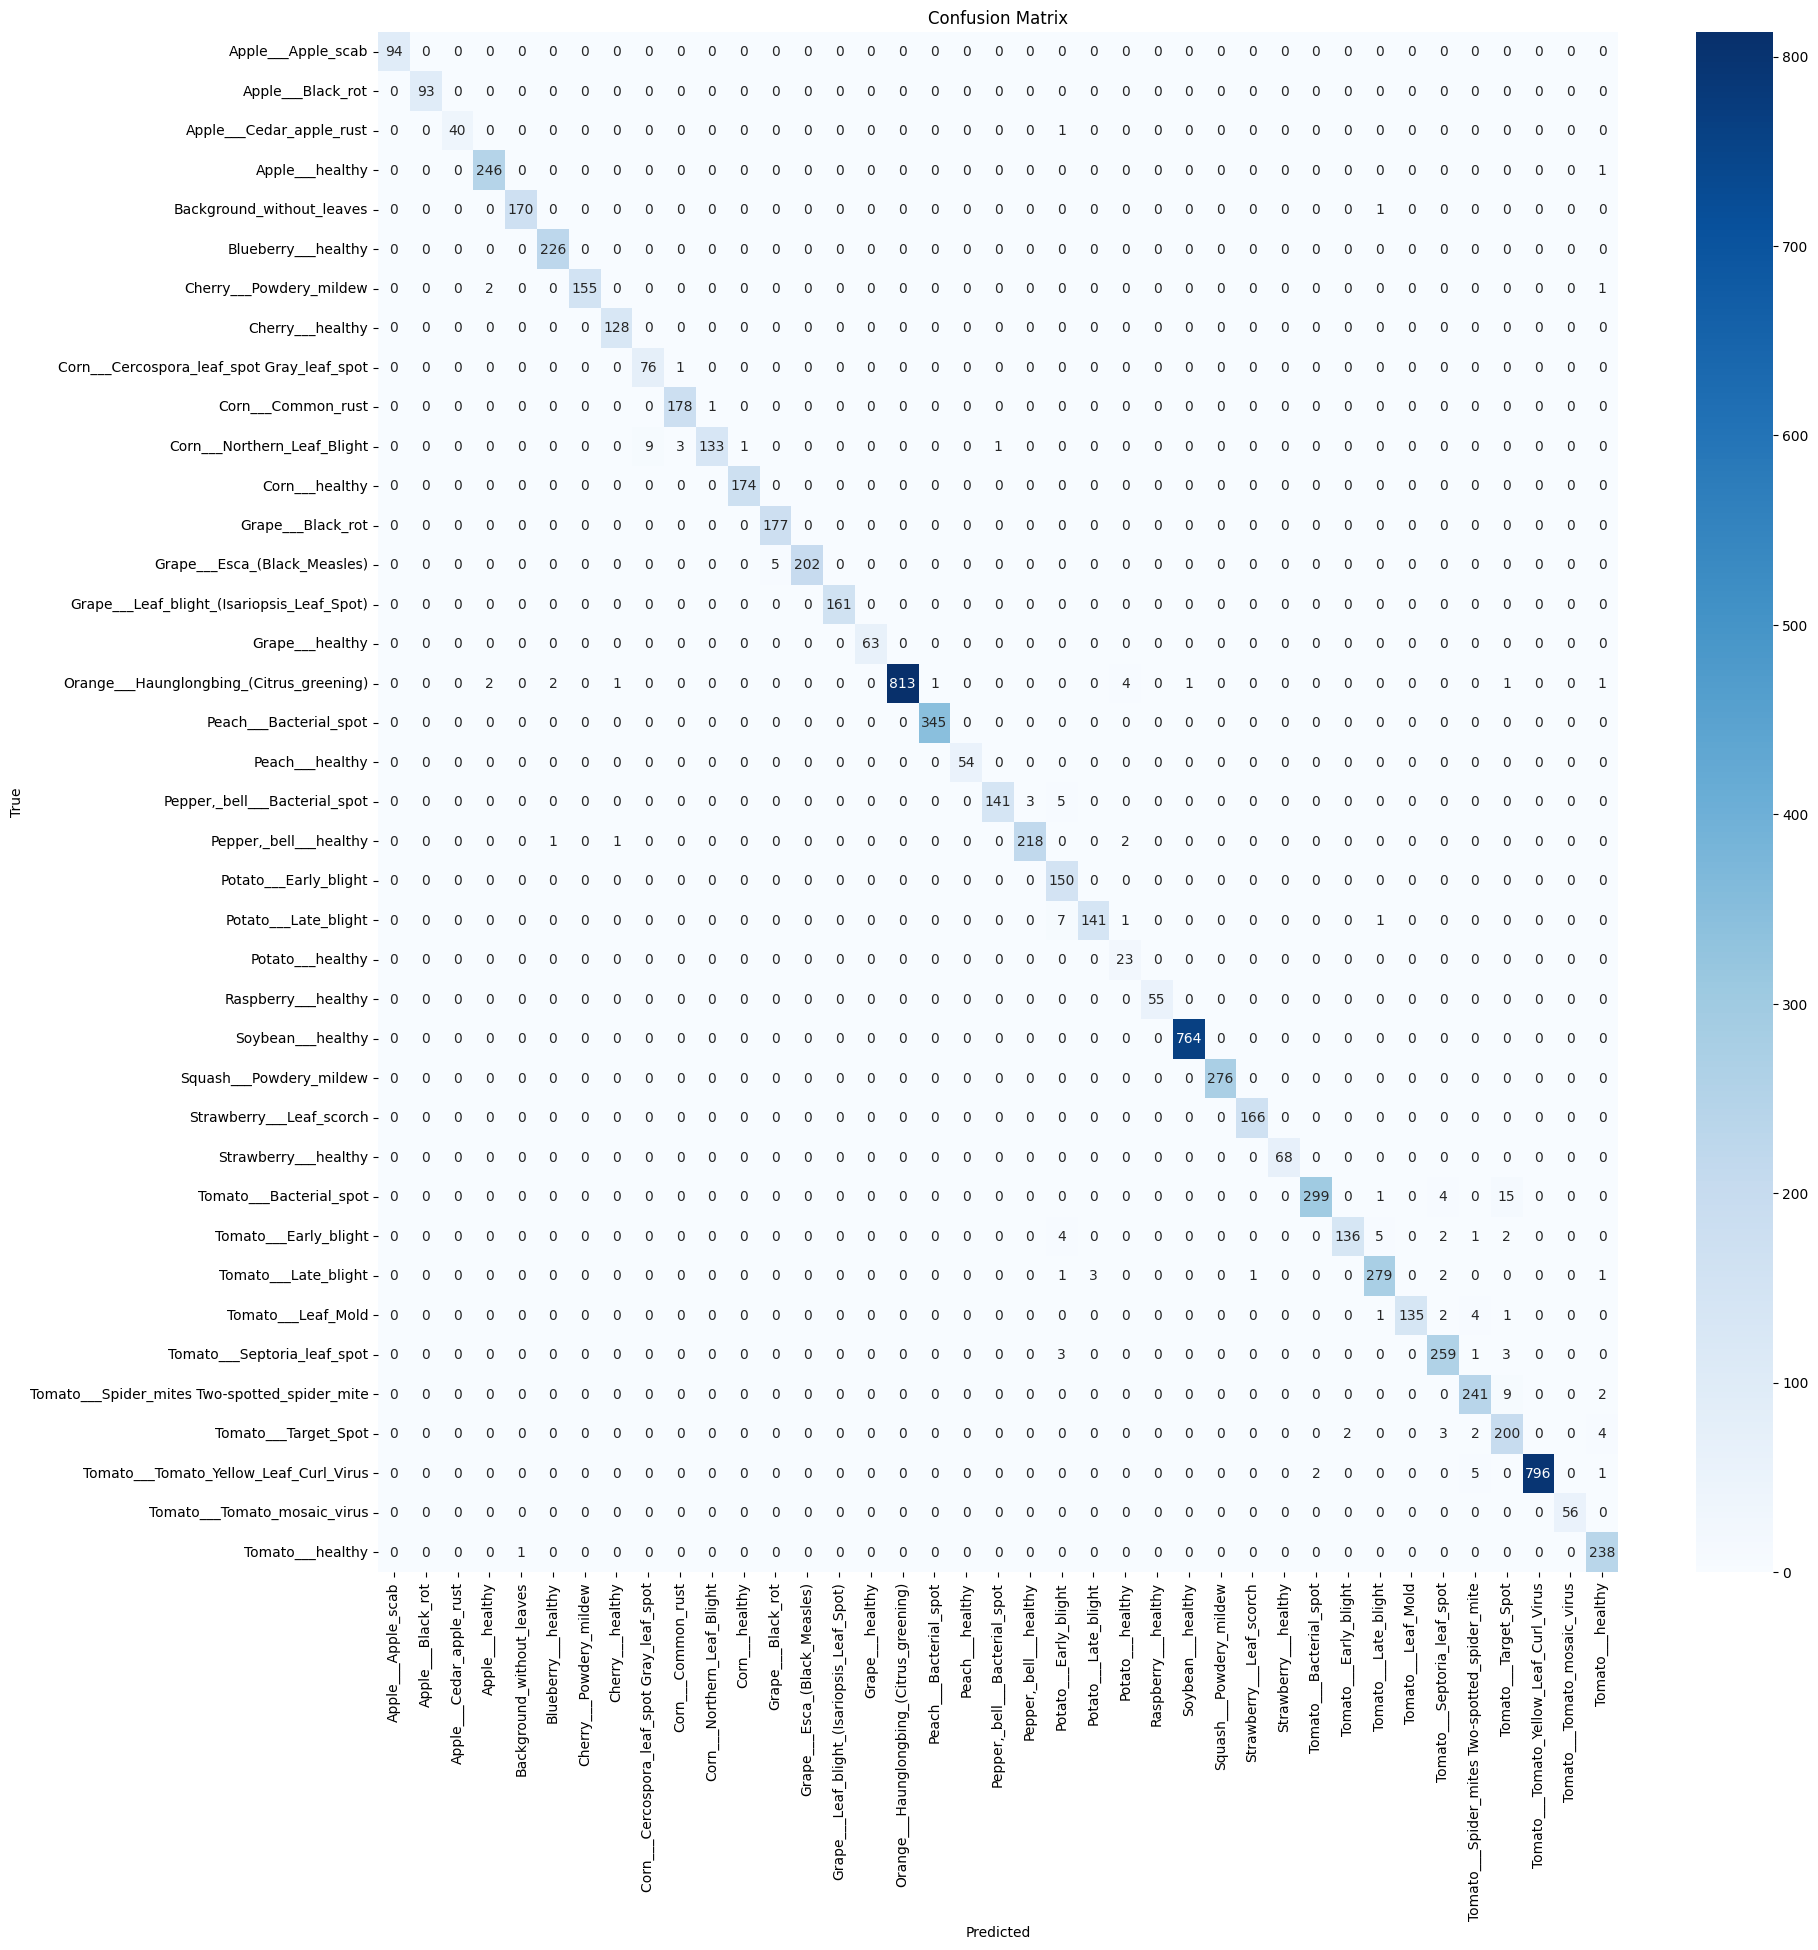

Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00        94
                            Apple___Black_rot       1.00      1.00      1.00        93
                     Apple___Cedar_apple_rust       1.00      0.98      0.99        41
                              Apple___healthy       0.98      1.00      0.99       247
                    Background_without_leaves       0.99      0.99      0.99       171
                          Blueberry___healthy       0.99      1.00      0.99       226
                      Cherry___Powdery_mildew       1.00      0.98      0.99       158
                             Cherry___healthy       0.98      1.00      0.99       128
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.99      0.94        77
                           Corn___Common_rust       0.98      0.99      0.99       179
                  

In [15]:
# 9. **Generate Confusion Matrix and Classification Report**

# Get true labels and predictions
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 10. **ROC and AUC**

# Since this is a multiclass problem, we need to binarize the labels
y_test_binarized = label_binarize(y_true, classes=range(num_classes))
y_pred_binarized = label_binarize(y_pred, classes=range(num_classes))


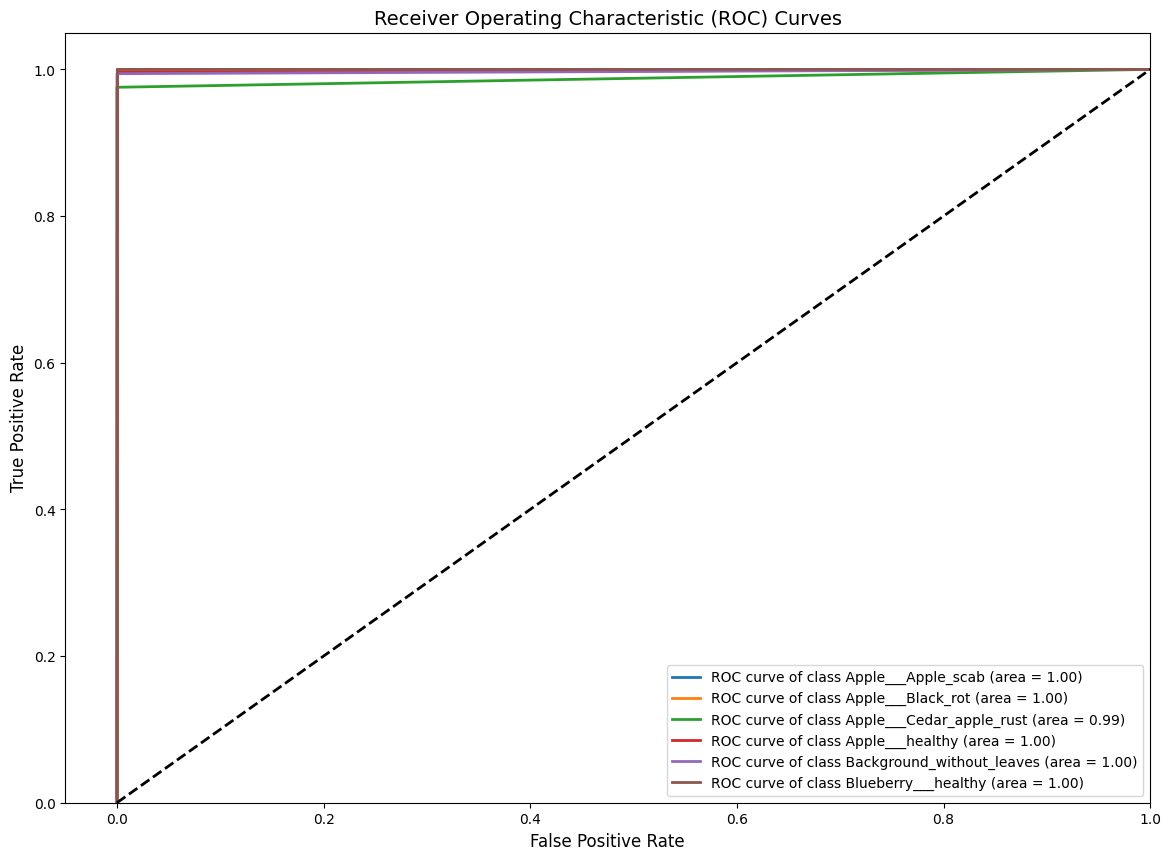

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for the first 6 classes as an example
plt.figure(figsize=(14, 10))
for i in range(min(num_classes, 6)):  # Adjust as needed
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.show()


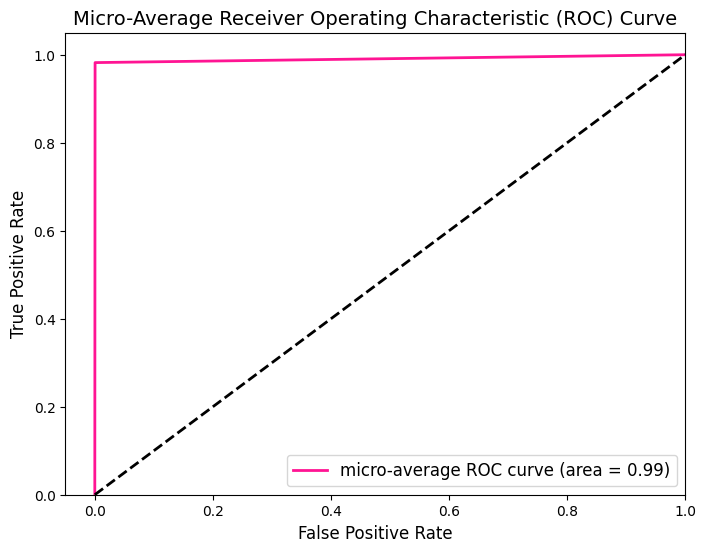

In [17]:
# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2,
         label=f'micro-average ROC curve (area = {roc_auc_micro:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()
